# Sommaire

* [Introduction](#Intro)
* [Description des données](#Desc)
* [construction du modèle](#Construction)

<a name="Intro"></a>
# Introduction 

Une problématique du *Machine Learning* est de permettre à la machine de comprendre la relation entre différentes variables. Cette compréhension lui permettra de faire des prédictions.

Un problème de régression peut se représenter comme un processus d’entrée/sortie:

$$ Y = \hat{f}(X) $$

X est la variable explicative et Y qui est une information continue, est la variable à expliquer.

# Sujet: la consommation de poulet 

Quelle est la relation entre la population et le nombre de poulet d’élevage?

## Description des données
<a name="Desc"></a>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns
from summer.metrics.errors import erreur_pour_plusieurs_parametres
from mpl_toolkits import mplot3d

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
FIGSIZE = (10,8)
VERBOSE = True

PREDICTOR_COL = "Population"
TARGET_COL = "taille du bétail"

## 0 - chargez et faites une rapide analyse descriptive

In [3]:
path_script = Path.cwd()
path_data = Path(path_script, "data")
csv_kwargs = dict(sep=";", encoding = "ISO-8859-1")

In [4]:
chicken = pd.read_csv(
    Path(path_data, "chicken.csv"),
    **csv_kwargs,
)

In [5]:
if VERBOSE:
    display(chicken.head())

,Code,Pays,Population,taille du bétail,Unit
0,BEN,Bénin,11175204,20470,1000 Head
1,BFA,Burkina Faso,19193284,42530,1000 Head
2,BDI,Burundi,10827024,2300,1000 Head
3,CMR,Cameroun,24566045,51100,1000 Head
4,TCD,Tchad,15016773,6169,1000 Head


Nous avons quatre variables dans la base de données. Une ligne de la base donne la population et la taille du bétail d’un certain nombre de pays. 

In [6]:
if VERBOSE:
    sample_country = "TCD"
    display(chicken.query("Code == @sample_country"))

,Code,Pays,Population,taille du bétail,Unit
4,TCD,Tchad,15016773,6169,1000 Head


In [7]:
chicken[chicken.Pays == "Bénin"]

,Code,Pays,Population,taille du bétail,Unit
0,BEN,Bénin,11175204,20470,1000 Head


In [8]:
expected_shape = (27, 5)
np.testing.assert_allclose(chicken.shape, expected_shape)

In [9]:
if VERBOSE:
    display(chicken.describe())

,Population,taille du bétail
count,2.700000e+01,27.000000
mean,1.567757e+07,33047.444444
std,1.215223e+07,41645.916336
min,1.828146e+06,433.000000
25%,4.906465e+06,3972.000000
50%,1.206754e+07,20470.000000
75%,2.450176e+07,43765.000000
max,4.116246e+07,199186.000000


## 1 - Identification des valeurs extrêmes

In [10]:
max_pop = max(chicken.Population)
chicken[chicken.Population == max_pop]

,Code,Pays,Population,taille du bétail,Unit
26,UGA,Ouganda,41162465,35683,1000 Head


In [11]:
df_chicken_sorted = chicken.sort_values(by=TARGET_COL, ascending=False)
highests = df_chicken_sorted.head(2)

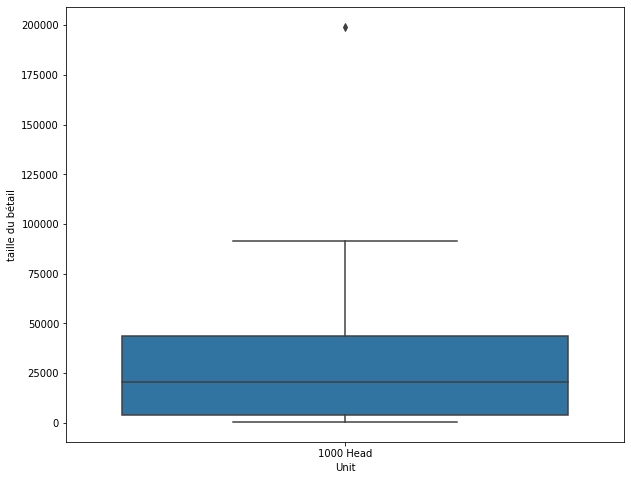

In [12]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.boxplot(y=TARGET_COL, x="Unit", data=chicken, ax=ax)
    plt.show()

In [13]:
expected_code_countries = {18: 'MAR', 25: 'TUN'}
assert highests["Code"].to_dict() == expected_code_countries

## 2 - visualisation de la relation entre les variables

In [14]:
outliers_labels = {}
for outlier in highests.to_dict(orient="records"):
    outlier_label = dict(
        x=outlier[PREDICTOR_COL]+100,
        y=outlier[TARGET_COL]+10,
        s=outlier["Pays"]
    )
    outliers_labels[outlier["Code"]] = outlier_label

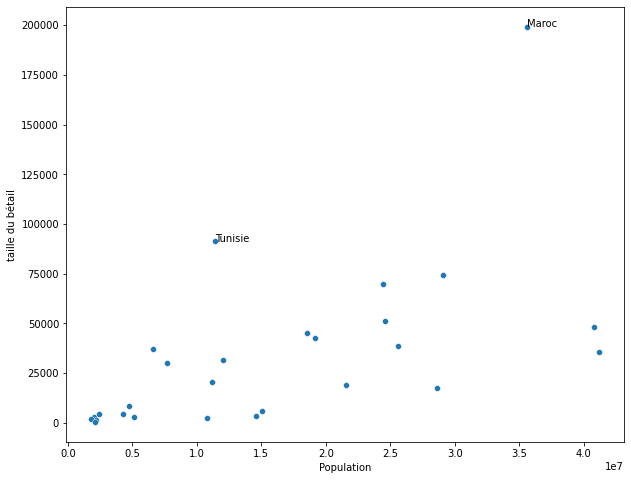

In [15]:
if VERBOSE:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.scatterplot(data=chicken, x=PREDICTOR_COL, y=TARGET_COL, ax=ax)
    for country_code in outliers_labels:
        plt.text(**outliers_labels[country_code])

    plt.show()

## Construction du modèle
<a name="Construction"></a>

In [16]:
df = chicken.drop(highests.index)
X, y = df[[PREDICTOR_COL]], df[TARGET_COL]

In [17]:
assert "MAR" not in df["Code"] and "TUN" not in df["Code"]


Le modèle suppose une relation linéaire entre:

* La variable explicative $X_{Population}$: la population
* La variable à expliquer $Y_{bétail}$: la taille du bétail

$$Y_{bétail} = \beta_1 \times X_{Population} + \beta_0~\overbrace{(+\epsilon)}^{incertitudes}$$
Il y a un terme d'erreur $\epsilon$ qui sert à tenir compte de tous les paramètres qu'on ne maîtrise pas comme le niveau de sécheresse au cours de l'année dans tel ou tel pays, le développement ponctuel d'une maladie aviaire $\dots{}$

Si la relation était sans incertitudes, on aurait besoin que de deux points (le Bénin et le Togo, par exemple) et on aurait:
$$ \beta_1=\frac{\Delta Y}{\Delta X}=\frac{Y_{bétail}^{Bénin}-Y_{bétail}^{Togo}}{X_{Population}^{Bénin}-X_{Population}^{Togo}}~~et~~\beta_0=Y_{bétail}^{Bénin}-\beta_1\times X_{Population}^{Bénin} $$

L'incertitude rend impossible une simple estimation des coefficients par ces formules. L'objectif est donc de trouver les paramètres $\beta_0$ et $\beta_1$ qui réduisent l'erreur au carré entre la droite et les points observés:
$$\sum_{i}(\overbrace{Y_i}^{observation}-\overbrace{(\beta_1 \times X_i + \beta_0)}^{modèle})^2= erreur~au~carré$$

## 2 - Description de l'erreur (approfondissement)

In [18]:
DIM_X = 200
DIM_Y = 200

coeff = np.linspace(0,0.002,DIM_X)
intercept = np.linspace(2000,10700,DIM_Y)

coeff_matrix, intercept_matrix = np.meshgrid(coeff, intercept)

In [19]:
erreur_quadratique = erreur_pour_plusieurs_parametres(
    coefficient_matrix = coeff_matrix, intercept_matrix = intercept_matrix, df = df, predictor_col = PREDICTOR_COL, target_col = TARGET_COL
)

In [21]:
coeff_matrix.shape

(200, 200)

In [22]:
intercept_matrix.shape

(200, 200)

In [23]:
erreur_quadratique.shape

(200, 200)

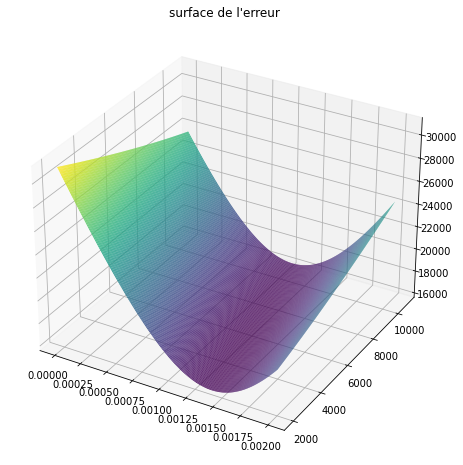

In [24]:
plt.figure(figsize=FIGSIZE)

ax = plt.axes(projection='3d')
ax.plot_surface(coeff_matrix, intercept_matrix, erreur_quadratique, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title("surface de l'erreur");

## 3 - Calibrage et prédiction du modèle

In [25]:
regressor = LinearRegression()
# Calibrage du modèle: détermination des coefficient
regressor.fit(X, y)

LinearRegression()

In [26]:
Y_model = regressor.predict(X)

In [27]:
expected_Y_model = [
    19039.50424144, 29456.62073701, 18587.14761474, 36436.9298933 ,
    24030.48360293, 11160.48285208, 36269.88352178,  7203.26661398,
    7396.94015841, 42355.35466942, 20198.82887378,  6895.77505979,
    7237.81113218, 10629.79205785, 13070.3403772 , 37741.97317476,
    28572.00615962, 10084.57617003, 41741.52785203,  7642.11152571,
    32586.64588714, 23474.87408821, 57545.54294173, 14522.52623467,
    57999.05456022
]
np.testing.assert_allclose(Y_model, expected_Y_model)

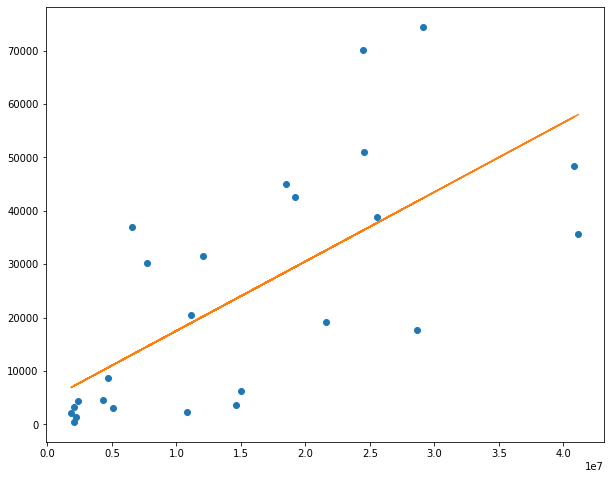

In [28]:
# Visualisation
if VERBOSE:
    fig, ax = plt.subplots(1,1, figsize=FIGSIZE)
    ax.plot(df[PREDICTOR_COL], df[TARGET_COL], "o")
    ax.plot(df[[PREDICTOR_COL]], Y_model)
    plt.show()

4 - Qu'aurait-on eu si nous avions gardé les valeurs aberrantes?

## Qu'est-ce qu'on retient? 

1. La Régression linéaire est un modèle où l'espérance de variable à expliquer est une fonction affine des paramètres
2. La moyenne est très sensible au valeur extrême. Il faut donc les identifier et les traiter
3. Le calibrage du modèle est une réduction (optimisation) de l'erreur quadratique

## Pour aller plus loin

1. Quels sont les hypothèses de la regression linéaire?
2. Comment les tester?
3. Que ferait-on si l'on avait plusieurs variables axplicatives?

---
# End of script
---